<a href="https://colab.research.google.com/github/heysourin/NLP-101/blob/main/LSTM/Microsoft%20Stock%20Pred/LSTM_Microsoft_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d vijayvvenkitesh/microsoft-stock-time-series-analysis

Dataset URL: https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis
License(s): CC0-1.0
  0% 0.00/26.7k [00:00<?, ?B/s]
100% 26.7k/26.7k [00:00<00:00, 43.0MB/s]


In [4]:
from zipfile import ZipFile
dataset = '/content/microsoft-stock-time-series-analysis.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Datat extracted!!!")

Datat extracted!!!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv('/content/Microsoft_Stock.csv', usecols=['Date', 'Close'], parse_dates=True)

In [74]:
df.shape

(1511, 2)

In [75]:
df.head()

,Date,Close
0,4/1/2015 16:00:00,40.72
1,4/2/2015 16:00:00,40.29
2,4/6/2015 16:00:00,41.55
3,4/7/2015 16:00:00,41.53
4,4/8/2015 16:00:00,41.42


In [76]:
# Converting into DateTime
from datetime import datetime

def date_object_handling(timeData):
  monthDateYear = timeData.split(' ')[0] # Taking only the part before space: '4/1/2015 16:00:00'
  [month, date, year] = monthDateYear.split('/') # Splitting based on '/'
  date = date + "-" + month + "-" + year
  date_format = "%d-%m-%Y"
  return datetime.strptime(date, date_format)

In [77]:
#Eg:
example_date = date_object_handling('4/1/2015 16:00:00')

example_date

datetime.datetime(2015, 4, 1, 0, 0)

In [78]:
df['Date'] = df['Date'].apply(date_object_handling)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date') #Setting date as index

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 to 2021-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1511 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [80]:
df.head()

,Close
Date,
2015-04-01,40.72
2015-04-02,40.29
2015-04-06,41.55
2015-04-07,41.53
2015-04-08,41.42


<Axes: xlabel='Date'>

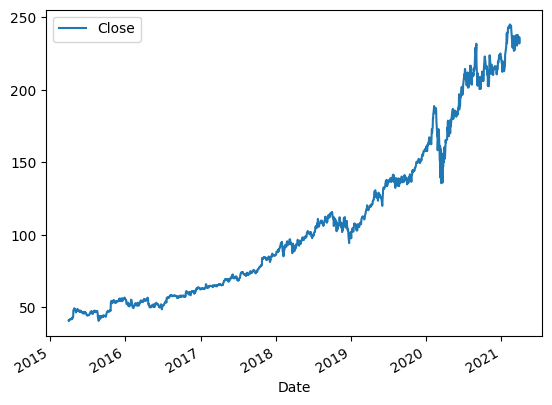

In [81]:
df.plot()
# or:
# plt.plot(df.index, df['Close'])

In [51]:
df.shape

(1511, 1)

In [85]:
train = df.iloc[:1200]
test = df.iloc[1200:]

In [86]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [87]:
df.head(), df.tail()

(            Close
 Date             
 2015-04-01  40.72
 2015-04-02  40.29
 2015-04-06  41.55
 2015-04-07  41.53
 2015-04-08  41.42,
              Close
 Date              
 2021-03-25  232.34
 2021-03-26  236.48
 2021-03-29  235.24
 2021-03-30  231.85
 2021-03-31  235.77)

In [88]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [89]:
scaled_train[:10]

array([[0.00357351],
       [0.        ],
       [0.0104712 ],
       [0.01030499],
       [0.00939084],
       [0.00988947],
       [0.01188399],
       [0.0122164 ],
       [0.01130225],
       [0.01637164]])

In [90]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [91]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [92]:
X,y = generator[3]
print(f'Given the Array: {X.flatten()}')
print(f'Predict this y: {y}')
print(f'Shape of X: {X.shape}')

Given the Array: [0.01030499 0.00939084 0.00988947]
Predict this y: [[0.01188399]]
Shape of X: (1, 3, 1)


In [61]:
# n_input = 12
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [95]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

In [96]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_input, n_features)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mse', metrics=["mean_absolute_error"])

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (78.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [98]:
model.fit(generator, epochs=5)

Epoch 1/5
1197/1197 [==============================] - 7s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0242
Epoch 2/5
1197/1197 [==============================] - 4s 3ms/step - loss: 3.1577e-04 - mean_absolute_error: 0.0135
Epoch 3/5
1197/1197 [==============================] - 5s 4ms/step - loss: 3.5448e-04 - mean_absolute_error: 0.0142
Epoch 4/5
1197/1197 [==============================] - 4s 3ms/step - loss: 4.2939e-04 - mean_absolute_error: 0.0155
Epoch 5/5
1197/1197 [==============================] - 4s 3ms/step - loss: 3.2594e-04 - mean_absolute_error: 0.0133


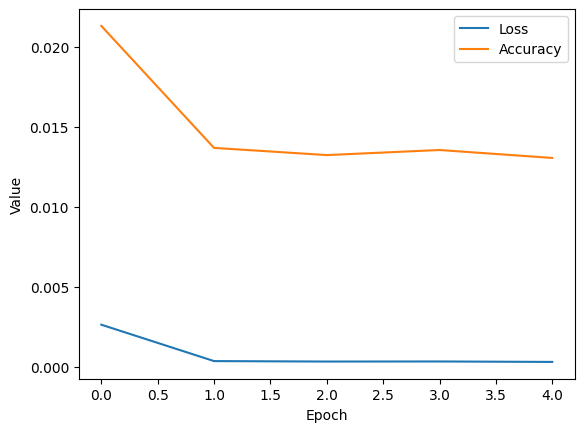

In [67]:
import matplotlib.pyplot as plt

loss_per_epoch = model.history.history['loss']
accuracy_per_epoch = model.history.history['mean_absolute_error']

# Plot loss
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label='Loss')

# Plot accuracy
plt.plot(range(len(accuracy_per_epoch)), accuracy_per_epoch, label='Accuracy')

# Set labels and legend
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.show()


In [106]:
# prediction
# Create a generator for the test set
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [107]:
predictions = model.predict(test_generator)

308/308 [==============================] - 1s 2ms/step


In [108]:
# Inverse transform the predictions to get the original scale
scaled_predictions = np.zeros((len(predictions), scaled_train.shape[1]))
scaled_predictions[:, 0] = predictions[:, 0]  # Only setting the 'Close' column
model_predictions = scaler.inverse_transform(scaled_predictions)[:, 0]

In [109]:
# Inverse transform the true values to get the original scale
scaled_true = np.zeros((len(scaled_test[n_input:]), scaled_train.shape[1]))
scaled_true[:, 0] = scaled_test[n_input:, 0]
original_true = scaler.inverse_transform(scaled_true)[:, 0]

In [110]:
# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(original_true, model_predictions)
mae = mean_absolute_error(original_true, model_predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 31.86075972102401
Mean Absolute Error: 4.554217572239299
Root Mean Squared Error: 5.644533614128275


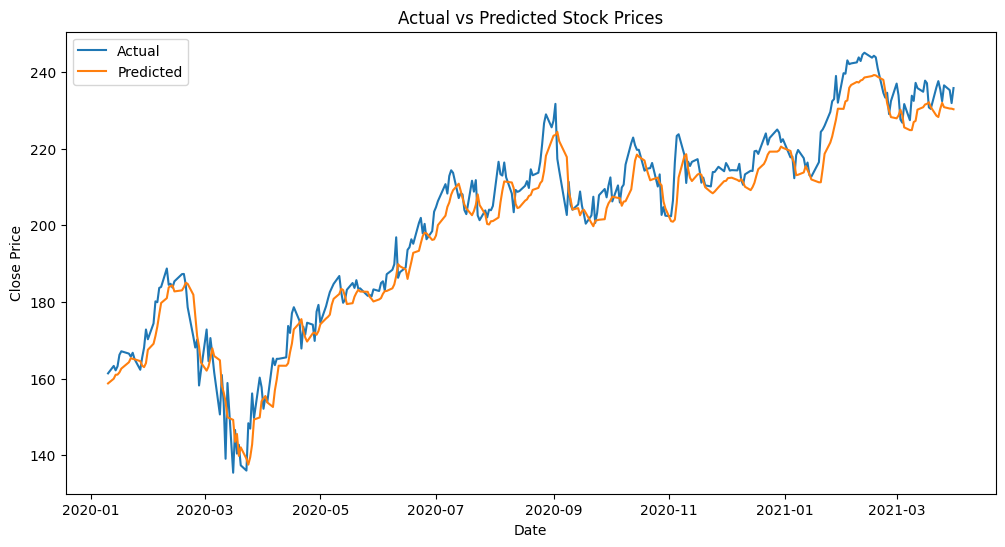

In [111]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(original_true):], original_true, label='Actual')
plt.plot(df.index[-len(model_predictions):], model_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()